In [13]:
import pandas as pd
import numpy as np

In [ ]:
train = pd.read_csv(f"../champ_result/GSE89093_all_beta_normalized.csv")

In [3]:
train_value = train.iloc[:, 1:]
train_value.head()

,0,1,2,3,4,5,6,7,8,9,...,82,83,84,85,86,87,88,89,90,91
0,0.486644,0.472790,0.440157,0.401009,0.403449,0.453738,0.505430,0.525945,0.539579,0.378885,...,0.586559,0.557733,0.515352,0.570047,0.586289,0.428182,0.410767,0.535594,0.561125,0.534982
1,0.989213,0.993538,0.991012,0.995878,0.996242,0.992823,0.990628,0.992809,0.999285,0.998130,...,0.980657,0.994747,0.987606,0.994711,0.982437,0.982954,0.994045,0.987665,0.993932,0.991112
2,0.984875,0.951471,0.948615,0.949571,0.963231,0.972137,0.972501,0.969343,0.950113,0.964967,...,0.966235,0.960497,0.955022,0.955616,0.936133,0.955798,0.937965,0.965013,0.942853,0.945216
3,0.102033,0.168589,0.158073,0.141595,0.124284,0.179538,0.181141,0.198009,0.171876,0.160247,...,0.164425,0.146259,0.162503,0.170724,0.151290,0.113963,0.176928,0.133602,0.147707,0.166224
4,0.798909,0.720664,0.745585,0.751120,0.738786,0.777767,0.776491,0.839313,0.830973,0.844176,...,0.795153,0.799779,0.796590,0.831788,0.794952,0.783985,0.720944,0.756649,0.848983,0.820339


In [4]:
phe = pd.read_csv("../champ_result/GSE89093_phenotype.csv")
phe = pd.DataFrame(phe["cancer_status"])
mask = phe == 'healthy'

In [9]:
train_normal = train_value.iloc[:,np.nonzero(mask.T)[1]]
train_tumor = train_value.iloc[:,np.nonzero(~mask.T)[1]]
train_normal = train_normal.T.reset_index(drop=True).T
train_tumor = train_tumor.T.reset_index(drop=True).T

,0,1,2,3,4,5,6,7,8,9,...,36,37,38,39,40,41,42,43,44,45
0,0.472790,0.403449,0.505430,0.525945,0.539579,0.464132,0.492984,0.525121,0.486808,0.565316,...,0.513869,0.552794,0.628597,0.554975,0.547020,0.586559,0.557733,0.570047,0.561125,0.534982
1,0.993538,0.996242,0.990628,0.992809,0.999285,0.993763,0.994670,0.991957,0.996651,0.988120,...,0.984695,0.989146,0.981003,0.989343,0.987200,0.980657,0.994747,0.994711,0.993932,0.991112
2,0.951471,0.963231,0.972501,0.969343,0.950113,0.952831,0.944027,0.936234,0.980138,0.905291,...,0.956056,0.957927,0.927795,0.927532,0.965320,0.966235,0.960497,0.955616,0.942853,0.945216
3,0.168589,0.124284,0.181141,0.198009,0.171876,0.185253,0.177354,0.205393,0.120393,0.172133,...,0.160116,0.259007,0.250401,0.315281,0.205794,0.164425,0.146259,0.170724,0.147707,0.166224
4,0.720664,0.738786,0.776491,0.839313,0.830973,0.776097,0.718977,0.770946,0.831703,0.804111,...,0.798206,0.869732,0.716751,0.857617,0.759182,0.795153,0.799779,0.831788,0.848983,0.820339
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
453622,0.017480,0.010956,0.009306,0.008481,0.001029,0.011709,0.008435,0.004261,0.004014,0.003202,...,0.003955,0.011066,0.012789,0.010466,0.016935,0.007897,0.004232,0.011549,0.016102,0.007668
453623,0.016064,0.004903,0.011053,0.009776,0.004001,0.016080,0.010604,0.006520,0.005961,0.009472,...,0.004420,0.006694,0.019083,0.019029,0.012968,0.010352,0.012666,0.008783,0.012630,0.017469
453624,0.025162,0.020435,0.012570,0.012651,0.001225,0.010856,0.012147,0.001945,0.009508,0.010087,...,0.014719,0.020208,0.043012,0.022159,0.013641,0.014115,0.024711,0.023771,0.032479,0.032993
453625,0.062762,0.059940,0.098019,0.132013,0.001345,0.091215,0.027082,0.055965,0.013220,0.043563,...,0.191182,0.213528,0.209121,0.209367,0.147617,0.135202,0.047782,0.072900,0.080214,0.182504


In [6]:
train_normal=train_normal.iloc[:-1,:]
train_tumor=train_tumor.iloc[:-1,:]


In [7]:
train_normal = train_normal.astype(float)
train_tumor = train_tumor.astype(float)
train_normal

,0,1,2,3,4,5,6,7,8,9,...,36,37,38,39,40,41,42,43,44,45
0,0.486644,0.440157,0.401009,0.453738,0.378885,0.365151,0.494895,0.541127,0.527334,0.650054,...,0.546201,0.414544,0.577215,0.533692,0.575377,0.515352,0.586289,0.428182,0.410767,0.535594
1,0.989213,0.991012,0.995878,0.992823,0.998130,0.993796,0.997399,0.996537,0.997079,0.987449,...,0.992986,0.989724,0.982051,0.994188,0.991435,0.987606,0.982437,0.982954,0.994045,0.987665
2,0.984875,0.948615,0.949571,0.972137,0.964967,0.962139,0.923158,0.949204,0.960519,0.939380,...,0.940197,0.962095,0.940848,0.950069,0.952367,0.955022,0.936133,0.955798,0.937965,0.965013
3,0.102033,0.158073,0.141595,0.179538,0.160247,0.154257,0.149419,0.232587,0.230122,0.163651,...,0.244649,0.169916,0.296618,0.167991,0.164750,0.162503,0.151290,0.113963,0.176928,0.133602
4,0.798909,0.745585,0.751120,0.777767,0.844176,0.833375,0.733397,0.818215,0.898583,0.858078,...,0.837832,0.846644,0.864834,0.797569,0.786011,0.796590,0.794952,0.783985,0.720944,0.756649
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
453621,0.005362,0.028908,0.014434,0.021568,0.005996,0.017631,0.009963,0.014628,0.008201,0.008092,...,0.020988,0.019443,0.023556,0.016155,0.022671,0.017175,0.019222,0.025421,0.030123,0.023574
453622,0.000802,0.013947,0.011970,0.011151,0.001347,0.008513,0.006538,0.004379,0.003929,0.008685,...,0.010112,0.006219,0.015125,0.014981,0.007930,0.011624,0.007974,0.015673,0.013178,0.014985
453623,0.003578,0.022522,0.009246,0.017005,0.003172,0.006886,0.008050,0.009474,0.006906,0.008764,...,0.012621,0.010331,0.016318,0.015867,0.011616,0.015397,0.011411,0.018158,0.014805,0.012377
453624,0.001104,0.030792,0.011537,0.014164,0.003596,0.020598,0.012452,0.006383,0.012921,0.013618,...,0.020220,0.030712,0.031359,0.027630,0.013404,0.018897,0.023488,0.024783,0.018400,0.021078


##### Calculate Δβ

In [11]:
# remove outlier based on every column
def IQR(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    upper_fence = Q3 + IQR*1.5
    lower_fence = Q1 - IQR*1.5
    return upper_fence,lower_fence
def no_outlier(df):
    upper_fence, lower_fence = IQR(df)
    ddf=df[(df>lower_fence)&(df<upper_fence)]
    return ddf

In [12]:
train_normal = no_outlier(train_normal)
train_tumor = no_outlier(train_tumor)

In [14]:
train_normal_avg = train_normal.mean(skipna=True, axis = 1)

In [15]:
train_tumor=(train_tumor).subtract(train_normal_avg, axis = 0)

In [16]:
train_tumor=no_outlier(train_tumor)

In [17]:
train_tumor_mean = train_tumor.mean(skipna=True, axis = 1)

In [18]:
dbeta = pd.merge(train.iloc[:-1,:1], pd.DataFrame(train_tumor_mean, columns = ["dbeta"]), left_index=True, right_index=True)
dbeta

,ID_REF,dbeta
0,cg00000029,0.009136
1,cg00000108,0.000004
2,cg00000109,0.002752
3,cg00000165,-0.003757
4,cg00000236,0.011955
...,...,...
453621,ch.9.97139671F,-0.000039
453622,ch.9.98463211R,-0.000344
453623,ch.9.98937537R,-0.000823
453624,ch.9.98957343R,0.000250


In [19]:
# rename ID_REF to ID
dbeta.rename(columns={"ID_REF": "ID"}, inplace=True)

Text(0.5, 1.0, 'Density plot of delta Beta value')

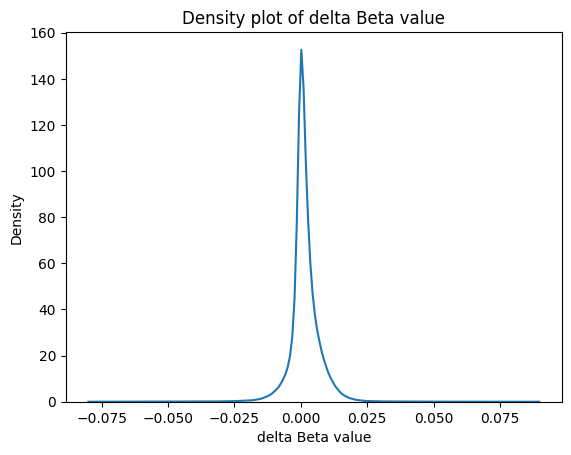

In [168]:
# %matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.kdeplot(dbeta['dbeta'], label='healthy')
plt.xlabel('delta Beta value')
plt.title('Density plot of delta Beta value')

In [ ]:
GPL13534 = pd.read_csv("../external_result/GPL13534-11288.txt", sep="\t")

In [ ]:
GPL13534.columns

In [21]:
GPL13534 = GPL13534[["ID", "UCSC_RefGene_Name", "UCSC_RefGene_Group"]]
GPL13534.dropna(inplace=True)
GPL13534

,ID,UCSC_RefGene_Name,UCSC_RefGene_Group
0,cg00035864,TTTY18,TSS1500
1,cg00050873,TSPY4;FAM197Y2,Body;TSS1500
2,cg00061679,DAZ1;DAZ4;DAZ4,Body;Body;Body
3,cg00063477,EIF1AY,Body
4,cg00121626,BCORL2,Body
...,...,...,...
485501,ch.22.734399R,EP300,Body
485502,ch.22.740407F,RANGAP1,Body
485503,ch.22.757911F,XRCC6,Body
485504,ch.22.772318F,NAGA,Body


In [22]:
result = pd.merge(dbeta, GPL13534, on="ID", how="inner")
result

,ID,dbeta,UCSC_RefGene_Name,UCSC_RefGene_Group
0,cg00000029,0.009136,RBL2,TSS1500
1,cg00000108,0.000004,C3orf35;C3orf35,Body;3'UTR
2,cg00000109,0.002752,FNDC3B;FNDC3B,Body;Body
3,cg00000236,0.011955,VDAC3;VDAC3,3'UTR;3'UTR
4,cg00000289,0.007991,ACTN1;ACTN1;ACTN1,3'UTR;3'UTR;3'UTR
...,...,...,...,...
344526,ch.9.357218F,0.002161,ADAMTSL1;ADAMTSL1,Body;Body
344527,ch.9.377428R,-0.001230,ACER2,Body
344528,ch.9.691424R,-0.000346,RNF38;RNF38;RNF38;RNF38;RNF38,3'UTR;3'UTR;3'UTR;3'UTR;3'UTR
344529,ch.9.837340R,-0.002480,PTAR1,Body


In [23]:
result['UCSC_RefGene_Name'] = result['UCSC_RefGene_Name'].str.split(';').str[0]
result['UCSC_RefGene_Group'] = result['UCSC_RefGene_Group'].str.split(';').str[0]
result.dropna(inplace=True)

In [24]:
def find_max_dBeta_grouped(group):
    idx_max = group['dbeta'].abs().idxmax()
    return group.loc[idx_max]

result_max_per_gene = result.groupby("UCSC_RefGene_Name").apply(find_max_dBeta_grouped).reset_index(drop=True)

C:\Users\Vincent\AppData\Local\Temp\ipykernel_4176\563322187.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result_max_per_gene = result.groupby("UCSC_RefGene_Name").apply(find_max_dBeta_grouped).reset_index(drop=True)


In [25]:
single = pd.read_csv('../comorbidity/matchgene174_single_3Y10__OR2.txt', sep='\t', header=None)

In [26]:
result_max_per_gene_single = result_max_per_gene[result_max_per_gene['UCSC_RefGene_Name'].isin(single[0])]
result_max_per_gene_single

,ID,dbeta,UCSC_RefGene_Name,UCSC_RefGene_Group
1,cg16531903,0.013321,A1CF,TSS1500
4,cg27166707,-0.006354,A2M,Body
5,cg24309769,-0.074597,A2ML1,Body
12,cg13001012,0.007991,AADAC,TSS1500
16,cg25628542,0.034433,AADAT,Body
...,...,...,...,...
19351,cg06155771,0.013769,ZNRD1,Body
19354,cg16483867,-0.013046,ZNRF3,Body
19371,cg22721334,-0.013064,ZSCAN18,1stExon
19391,cg16899823,-0.021684,ZWINT,TSS200


In [14]:
file_endings="GSE89093"

In [28]:
result_max_per_gene_single.to_csv(f"../result/result_basic_dbeta_{file_endings}.csv", index=False)

Lazy reading, skip when exectuing the code from top to bottom.

In [15]:
result_basic_dbeta = pd.read_csv(f"../result/result_basic_dbeta_{file_endings}.csv")

In [16]:
dbeta_process_liquid = result_basic_dbeta.copy()
dbeta_process_liquid

,ID,dbeta,UCSC_RefGene_Name,UCSC_RefGene_Group
0,cg16531903,0.013321,A1CF,TSS1500
1,cg27166707,-0.006354,A2M,Body
2,cg24309769,-0.074597,A2ML1,Body
3,cg13001012,0.007991,AADAC,TSS1500
4,cg25628542,0.037536,AADAT,Body
...,...,...,...,...
8119,cg06155771,0.013769,ZNRD1,Body
8120,cg16483867,-0.013046,ZNRF3,Body
8121,cg22721334,-0.013064,ZSCAN18,1stExon
8122,cg16899823,-0.021684,ZWINT,TSS200


Filter by TSS1500 & TSS200 (Optional)

In [22]:
# remove rows that UCSC_RefGene_Group != 'TSS200' or 'TSS1500'
dbeta_process_liquid = dbeta_process_liquid[dbeta_process_liquid['UCSC_RefGene_Group'].isin(['TSS200', 'TSS1500'])]
dbeta_process_liquid

,ID,dbeta,UCSC_RefGene_Name,UCSC_RefGene_Group
0,cg16531903,0.013321,A1CF,TSS1500
3,cg13001012,0.007991,AADAC,TSS1500
12,cg13970341,-0.015888,ABCA2,TSS1500
15,cg06409153,-0.007949,ABCA5,TSS1500
19,cg00295325,0.003256,ABCB11,TSS200
...,...,...,...,...
8110,cg16977510,-0.015332,ZNF717,TSS200
8112,cg10366407,-0.015157,ZNF763,TSS200
8113,cg01493567,0.007572,ZNF84,TSS1500
8115,cg02747612,0.011503,ZNF91,TSS1500


Intersect with tissue train dbeta(optional)

In [18]:
result_max_per_gene_single = pd.read_csv(f"../result/result_basic_process.csv")

In [19]:
dbeta_process_tissue = result_max_per_gene_single.copy()
dbeta_process_tissue.columns = ['ID', 'dbeta', 'UCSC_RefGene_Name']
dbeta_process_tissue

,ID,dbeta,UCSC_RefGene_Name
0,cg00134295,0.207143,A2M
1,cg15769388,-0.143162,A2ML1
2,cg13001012,-0.056940,AADAC
3,cg00150882,0.157614,AADAT
4,cg20940607,0.009114,AAGAB
...,...,...,...
7853,cg07135797,-0.288723,ZNRD1
7854,cg20080983,-0.261198,ZNRF3
7855,cg14231297,0.401591,ZSCAN18
7856,cg14642833,-0.018417,ZWINT


In [20]:
# intersect between liquid and tissue
interseted = pd.merge(dbeta_process_liquid, dbeta_process_tissue, on="ID", how="inner")
interseted = interseted[(interseted['dbeta_x'] * interseted['dbeta_y']) > 0]
interseted = interseted.drop(columns=['UCSC_RefGene_Name_y'])
interseted = interseted.rename(columns={'UCSC_RefGene_Name_x': 'UCSC_RefGene_Name'})
interseted = interseted.rename(columns={'dbeta_x': 'dbeta_liquid'})
interseted = interseted.rename(columns={'dbeta_y': 'dbeta_tissue'})
interseted = interseted[['ID', 'UCSC_RefGene_Name', 'dbeta_liquid', 'dbeta_tissue']]
print(interseted.shape)
interseted

(121, 4)


,ID,UCSC_RefGene_Name,dbeta_liquid,dbeta_tissue
1,cg00295325,ABCB11,0.003256,0.084160
2,cg18265608,ACCS,0.008058,0.247523
8,cg03547181,ADORA1,0.008244,0.220213
11,cg12001930,AKR1B10,0.017235,0.051842
13,cg22468803,ANKRD12,-0.022905,-0.032390
...,...,...,...,...
360,cg17665699,ULK2,0.017981,0.155224
362,cg15199408,USO1,-0.017796,-0.016795
365,cg19969694,VPS18,0.010080,0.211612
366,cg14870223,WDR48,0.018116,0.122223


C:\Users\Vincent\AppData\Local\Temp\ipykernel_4176\2185245085.py:6: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.scatterplot(


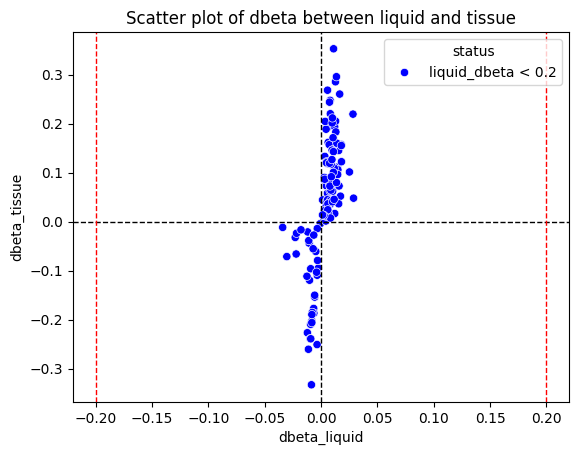

In [38]:
# draw scatter plot for liquid and tissue
import matplotlib.pyplot as plt
import seaborn as sns
interseted['status'] = np.where(abs(interseted['dbeta_liquid']) < 0.2, 'liquid_dbeta < 0.2', 'liquid_dbeta >= 0.2')

sns.scatterplot(
    data=interseted,
    x='dbeta_liquid',
    y='dbeta_tissue',
    hue='status',
    palette=['blue', 'gray'])
plt.xlabel('dbeta_liquid')
plt.ylabel('dbeta_tissue')
plt.title('Scatter plot of dbeta between liquid and tissue')
plt.axhline(0, color='black', linewidth=1, linestyle='--')
plt.axvline(0, color='black', linewidth=1, linestyle='--')
plt.axvline(0.2, color='red', linewidth=1, linestyle='--')
plt.axvline(-0.2, color='red', linewidth=1, linestyle='--')
plt.show()

In [ ]:
interseted = interseted[abs(interseted['dbeta_liquid']) >= 0.02]
# interseted = interseted.drop(columns=['status'])
print(interseted.shape)
interseted

In [14]:
interseted.to_csv(f"../result/train_and_GSE89093_interseted.csv", index=False)

dbeta thresholding 

In [24]:
dbeta_process_liquid = dbeta_process_liquid[abs(dbeta_process_liquid['dbeta']) >= 0.02]
print(dbeta_process_liquid.shape)
dbeta_process_liquid

(341, 4)


,ID,dbeta,UCSC_RefGene_Name,UCSC_RefGene_Group
21,cg14878128,0.028270,ABCB5,TSS200
33,cg05639842,-0.029205,ABCG1,TSS1500
51,cg10523679,0.020107,ACADM,TSS1500
83,cg10607155,-0.023059,ACTG1,TSS1500
101,cg25717799,-0.034555,ACY1,TSS200
...,...,...,...,...
8017,cg26219488,0.031328,ZFR,TSS1500
8043,cg21664828,-0.030598,ZNF148,TSS1500
8066,cg10023249,-0.023021,ZNF331,TSS200
8097,cg19230575,-0.021506,ZNF639,TSS200


In [25]:
dbeta_process_liquid.to_csv(f"../result/train_and_GSE89093_liquid_0.02.csv", index=False)